In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model

from pmdarima import auto_arima  # Auto-tuning ARIMA parameters

from modules.utils import feature_engineering_last, filter_data_by_year_month

In [3]:
X = pd.read_csv(
   "/Users/elouan/A. Repo Github ElouanBahri/Predicting_crypto_prices/Historical Prices for BTCUSDT"
)

In [30]:
YEARS = [2020, 2021, 2022, 2023, 2024, 2025]

Data = filter_data_by_year_month(X, YEARS)


------------------------------------------------
Some graphs on the return 

In [31]:
Data["return"] = np.log(Data["close"] / Data["close"].shift(1))
Data["scaled_returns"] = Data["return"].dropna() * 100

Data["timestamp"] = pd.to_datetime(Data["timestamp"])
Data.set_index("timestamp", inplace=True)


/var/folders/41/lv7xy5r91x7ckkgx5zqmgpxh0000gn/T/ipykernel_86644/3147666794.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data["return"] = np.log(Data["close"] / Data["close"].shift(1))
/var/folders/41/lv7xy5r91x7ckkgx5zqmgpxh0000gn/T/ipykernel_86644/3147666794.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data["scaled_returns"] = Data["return"].dropna() * 100
/var/folders/41/lv7xy5r91x7ckkgx5zqmgpxh0000gn/T/ipykernel_86644/3147666794.py:4: SettingWithCopyWarning: 
A value is trying to be set on

<Figure size 1000x400 with 0 Axes>

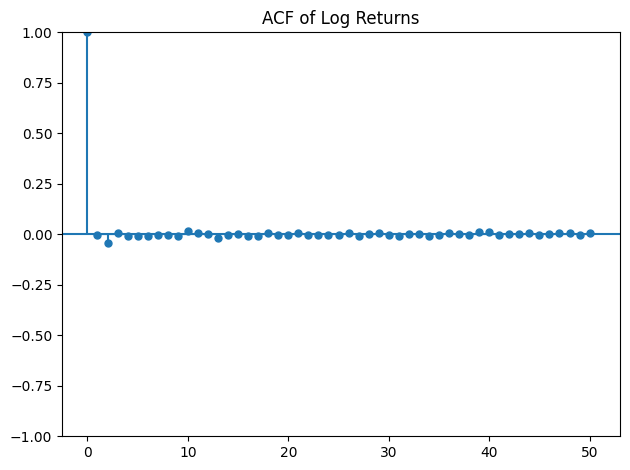

In [34]:

plt.figure(figsize=(10, 4))
plot_acf(Data["scaled_returns"].dropna(), lags=50)
plt.title("ACF of Log Returns")
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

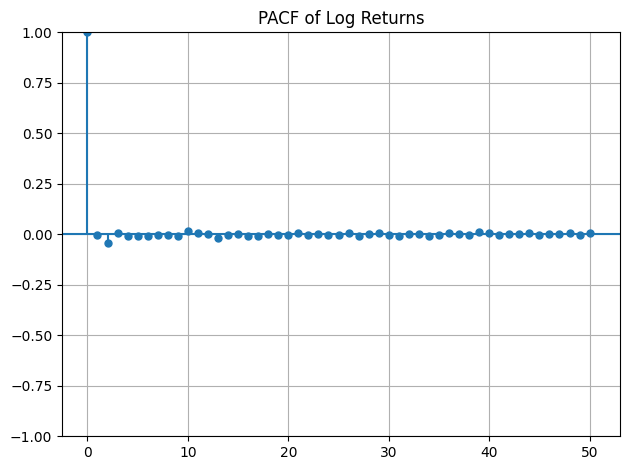

In [22]:


plt.figure(figsize=(10, 4))
plot_pacf(Data["return"].dropna(), lags=50, alpha=0.05, method='ywm')
plt.title("PACF of Log Returns")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
# 96 periods = 1 day if using 15-min intervals
rolling_window = 96

Data["rolling_mean"] = Data["scaled_returns"].rolling(rolling_window).mean()
Data["rolling_vol"] = Data["scaled_returns"].rolling(rolling_window).std()

/var/folders/41/lv7xy5r91x7ckkgx5zqmgpxh0000gn/T/ipykernel_86644/1121686484.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data["rolling_mean"] = Data["scaled_returns"].rolling(rolling_window).mean()
/var/folders/41/lv7xy5r91x7ckkgx5zqmgpxh0000gn/T/ipykernel_86644/1121686484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data["rolling_vol"] = Data["scaled_returns"].rolling(rolling_window).std()


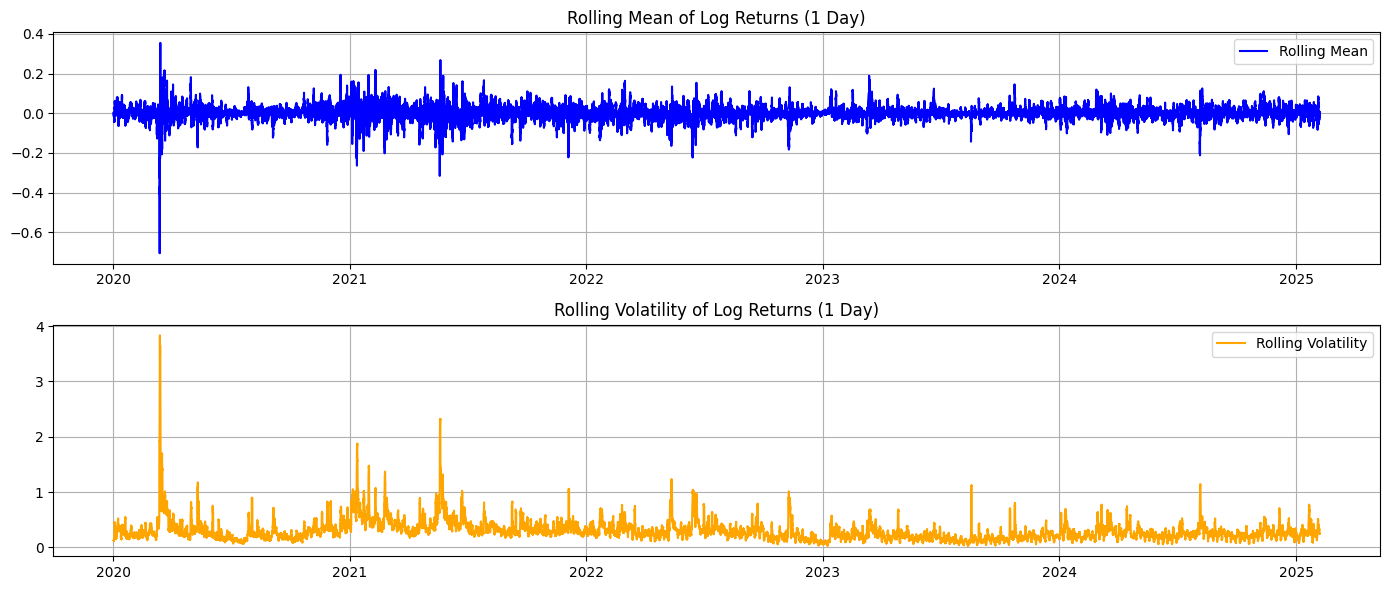

In [36]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(Data["rolling_mean"], label="Rolling Mean", color="blue")
plt.title("Rolling Mean of Log Returns (1 Day)")
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(Data["rolling_vol"], label="Rolling Volatility", color="orange")
plt.title("Rolling Volatility of Log Returns (1 Day)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [37]:
result = adfuller(Data["return"].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])

for key, value in result[4].items():
    print(f"Critical Value {key}: {value}")

ADF Statistic: -45.88572461582736
p-value: 0.0
Critical Value 1%: -3.430386604910012
Critical Value 5%: -2.861556178875227
Critical Value 10%: -2.566778611435469


We can conclude that the return are stationary !

-------------------------------------------------

In [24]:
returns = Data["return"].dropna()

In [25]:
# after observing the graph of acf and pacf we try first an ARMA(1,1)
model = ARIMA(returns, order=(1, 0, 1))
result = model.fit()
print(result.summary())

/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/elouan/anaconda3/envs/Predicting_crypto/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:               178728
Model:                 ARIMA(1, 0, 1)   Log Likelihood              751126.811
Date:                Sat, 10 May 2025   AIC                       -1502245.622
Time:                        10:56:55   BIC                       -1502205.247
Sample:                             0   HQIC                      -1502233.680
                             - 178728                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.463e-05   8.54e-06      1.712      0.087   -2.12e-06    3.14e-05
ar.L1         -0.0612      0.000   -259.560      0.000      -0.062      -0.061
ma.L1          0.0587      0.000    248.949      0.0

## ARMA(1,1) Model Summary — Log Returns

### Model Overview

- **Model**: ARIMA(1, 0, 1) → equivalent to ARMA(1,1)
- **Observations**: 178,728 (15-min frequency)
- **Log Likelihood**: 751,126.811
- **AIC**: -1,502,245.622 → lower = better fit
- **BIC**: -1,502,205.247

### Coefficient Estimates

| Term     | Coefficient | P-value | Interpretation |
|----------|-------------|---------|----------------|
| `const`  | 1.46e-05    | 0.087   | Drift (not significant) |
| `ar.L1`  | -0.0612     | <0.001  | Weak negative autocorrelation |
| `ma.L1`  | 0.0587      | <0.001  | Positive short-term smoothing |
| `sigma²` | 1.31e-05    | <0.001  | Variance of residuals |

→ All coefficients except const are statistically significant



### Residual Diagnostics

- **Ljung-Box Test (lag 1)**: Q = 0.01, p = 0.92  
  → ✅ Residuals are uncorrelated (white noise)

- **Jarque-Bera Normality Test**: JB = 93,238,030, p < 0.001  
  → ❌ Returns are **not normally distributed** (heavy tails, high kurtosis)

- **Heteroskedasticity (H-test)**: H = 0.32, p < 0.001  
  → ❌ Residuals show **volatility clustering** → consider GARCH



### Summary & Recommendation

- ✅ The ARMA(1,1) model is statistically significant and captures minor autocorrelation.
- ❌ The residuals are **not normally distributed**, and **variance is not constant**.
- **Conclusion**: ARMA is useful for baseline return modeling, but volatility needs its own model.



### Next Step:

- Fit a **GARCH(1,1)** model on the return series (or ARMA residuals)
- Combine return + volatility forecasts for regime-aware trading strategy

------------------

Prediction with ARMA

-------------

## Why Use GARCH for Modeling Returns?

### ❓ What's the problem with just ARMA or ARIMA?

While ARMA/ARIMA models are good for capturing **mean-level dynamics** (like trend, autocorrelation), they assume **constant variance** (homoskedasticity). But...

> **Financial returns — especially in crypto — have time-varying volatility.**

This means:
- Volatility **clusters** (high-volatility periods are followed by high-volatility ones)
- Shocks **persist** over time
- Standard models underestimate **risk**

---

### ✅ What is GARCH?

**GARCH** stands for:
> **Generalized Autoregressive Conditional Heteroskedasticity**

It is used to **model and forecast the volatility (variance)** of a time series.

---

### 🧠 How GARCH(1,1) works:

In GARCH, you model **variance at time t** as:

$$
\sigma_t^2 = \omega + \alpha \cdot \epsilon_{t-1}^2 + \beta \cdot \sigma_{t-1}^2
$$

Where:
- $ \omega $ = long-term average volatility
- $ \alpha $ = how much recent shocks affect today's volatility
- $ \beta $ = how much past volatility persists
- $ \epsilon_{t-1}^2 $ = squared residual (previous error)

---

### 🔍 Why GARCH is needed

| Feature | Explanation |
|---------|-------------|
| **Volatility clustering** | GARCH captures this automatically |
| **Crypto is non-linear** | GARCH handles conditional variance |
| **Risk management** | GARCH forecasts future volatility for position sizing |
| **Trading signals** | Use volatility prediction to adjust leverage or avoid choppy regimes |

---

### ✅ When GARCH is useful

- ACF of squared returns has significant spikes
- Ljung-Box test on squared returns → **p < 0.05**
- You observe **non-constant rolling volatility**
- Your ARMA residuals have time-varying variance

---

### 🔁 What's the output of a GARCH model?

After fitting, you get:
- **Forecasted volatility**
- Model parameters: $ \omega, \alpha, \beta $
- Residuals (which should now be white noise)

You can use:
- $ \sigma_t $ as a **risk metric**
- Combine with ARMA return forecast: e.g. `signal = f(predicted return / predicted volatility)`

---


In [28]:
scaled_returns = Data["return"].dropna() * 100

garch = arch_model(scaled_returns, vol="Garch", p=1, q=1, mean="Zero")
garch_result = garch.fit()
print(garch_result.summary())

Iteration:      1,   Func. Count:      4,   Neg. LLF: 20818.366378307153
Optimization terminated successfully    (Exit mode 0)
            Current function value: 20818.367655987215
            Iterations: 5
            Function evaluations: 4
            Gradient evaluations: 1
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -20818.4
Distribution:                  Normal   AIC:                           41642.7
Method:            Maximum Likelihood   BIC:                           41673.0
                                        No. Observations:               178728
Date:                Sat, May 10 2025   Df Residuals:                   178728
Time:                        11:21:55   Df Model:                            0
         

### ✅ Key Insights

•	Volatility Clustering:
$\alpha + \beta$ = 0.98

This is very close to 1, meaning shocks to volatility decay slowly → perfect case for GARCH!

•	All parameters are statistically significant (P < 0.001)
•	Optimization succeeded (Exit mode 0)

→ Model is now correctly fit and stable.


----

Forecasting

In [39]:
vol_forecast = garch_result.forecast(horizon=10)
print(vol_forecast.variance[-1:])

                        h.01      h.02      h.03      h.04      h.05  \
timestamp                                                              
2025-02-06 08:15:00  0.02579  0.027894  0.029955  0.031976  0.033956   

                         h.06      h.07      h.08      h.09      h.10  
timestamp                                                              
2025-02-06 08:15:00  0.035896  0.037797  0.039661  0.041487  0.043277  


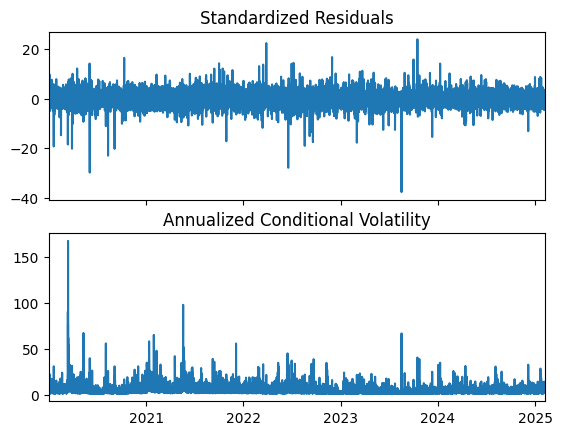

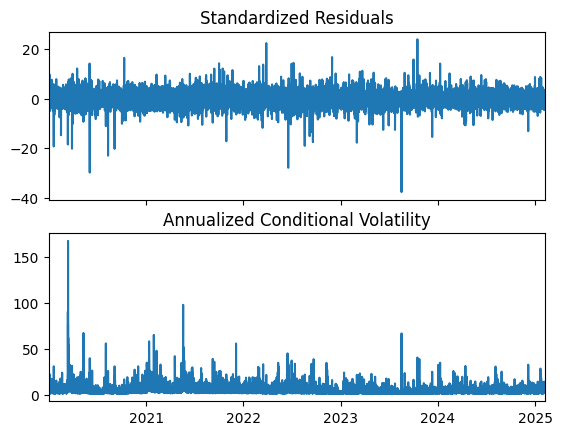

In [40]:
garch_result.plot(annualize='D')  # or use None if 15-min data